# MFE 413: Data Analytics and Machine Learning

## Problem Set 4

### Cohort 2 Group 5
* Chen Yechao
* Chopra Aryan
* Gonzalez Rivadeneira Sara
* Jensen Mathieu
* Kumar Pranay

#### Using the DT_StockRetAcct.csv dataset available at BruinLearn (Week 1), we will in this exercise code up a "machine learning" version of valuation using comparables, and we will use this valuation tool to form trading strategies. That is, we will program an automated learning routine that finds the model specification -- which variables to include and the functional form these variables take -- and evaluate the out-of-sample performance of this model. As described in the lecture notes for Topic 4, we will use the Elastic Net procedure, which includes Ridge Regressions and LASSO as special cases. 

In [36]:
import numpy as np
import pandas as pd
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from linearmodels.panel import PanelOLS, FamaMacBeth
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import cross_val_score, RepeatedKFold

import warnings
warnings.filterwarnings("ignore")

# Question 1: Valuation with Machine Learning, version 1

### a). We will predict current log equity market value, lnME. Next, we will construct the features we will use to do so. First, create log book value by setting lnBE = lnBM + lnME. That is, add the log market value to the log book-to-market ratio. Next, in addition to lnBE, we will also consider the characteristics lnIssue, lnProf, lnInv, lnLever, lnMOM, lnROE, and rv. Thus, you have eight characteristics in total. For each of these seven characteristics, create new, additional characteristics as the squared value of the original characteristic. Name the new characteristics the same as the original, but with a "2" at the end. For instance, for lnProf, the squared value should be lnProf2. Also, create interaction terms where you multiply each of these characteristics with lnBE (except lnBE itself, as this would simply give lnBE^2, which you already have). Finally, create 11 dummy variables using the ff_ind industry variable. There are twelve possible industries, but skip the 12th one when creating dummies as the regressions we will run have intercepts. You should now have 8+8+7+11 features that you will use to predict lnME. 

In [37]:
data = pd.read_csv("StockRetAcct_DT.csv")
data = data.dropna()

data["lnBE"] = data["lnBM"] + data["lnME"]

data["lnBE2"]           = data["lnBE"]**2
data["lnIssue2"]        = data["lnIssue"]**2
data["lnProf2"]         = data["lnProf"]**2
data["lnInv2"]          = data["lnInv"]**2
data["lnLever2"]        = data["lnLever"]**2
data["lnMom2"]          = data["lnMom"]**2
data["lnROE2"]          = data["lnROE"]**2
data["rv2"]             = data["rv"]**2

data["lnBElnIssue"]     = data["lnBE"]*data["lnIssue"]
data["lnBElnProf"]      = data["lnBE"]*data["lnProf"]
data["lnBElnInv"]       = data["lnBE"]*data["lnInv"]
data["lnBElnLever"]     = data["lnBE"]*data["lnLever"]
data["lnBElnMom"]       = data["lnBE"]*data["lnMom"]
data["lnBElnROE"]       = data["lnBE"]*data["lnROE"]
data["lnBErv"]          = data["lnBE"]*data["rv"]

industryDummies = (pd.get_dummies(data['ff_ind'], prefix='Industry').iloc[:, :-1]).astype(int)
data = data.join(industryDummies)

### i). For each year in the sample, run a cross-sectional regression of lnME on these features. Get the predicted values lnME_hat from this regression each year. Plot the R2 from these regressions across the years in the sample. That is, R2 on the y axis and year on the x axis. Comment on any interesting patterns you see in terms of this model’s ability to explain equity market values across firms.

In [38]:
features = ['lnBE', 'lnIssue', 'lnProf', 'lnInv', 'lnLever', 'lnMom', 'lnROE', 'rv',
            'lnBE2', 'lnIssue2', 'lnProf2', 'lnInv2', 'lnLever2', 'lnMom2', 'lnROE2', 'rv2',
            'lnBElnIssue', 'lnBElnProf', 'lnBElnInv', 'lnBElnLever', 'lnBElnMom', 'lnBElnROE', 'lnBErv',
            'Industry_1.0', 'Industry_2.0', 'Industry_3.0', 'Industry_4.0', 'Industry_5.0', 'Industry_6.0',
            'Industry_7.0', 'Industry_8.0', 'Industry_9.0', 'Industry_10.0', 'Industry_11.0']    
X = data[features]
X = sm.add_constant(X)
y = data['lnME']

regression = sm.OLS(y, X).fit()

In [39]:
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                   lnME   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     9587.
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:22:48   Log-Likelihood:                -48880.
No. Observations:               58378   AIC:                         9.783e+04
Df Residuals:                   58343   BIC:                         9.814e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.8223      0.158     43.184

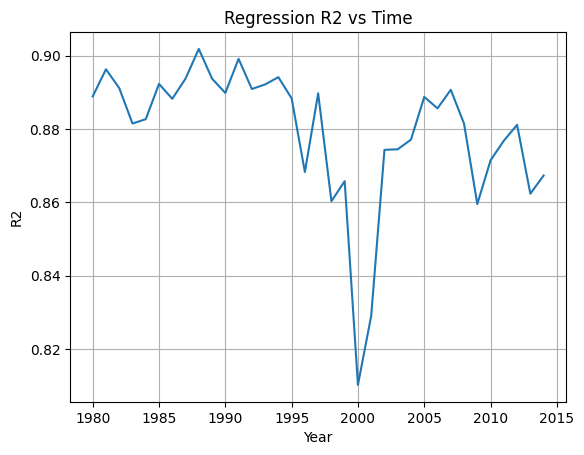

In [40]:
lnME_hat = []
R2 = []

for year, group in data.groupby('year'):
    
    X = group[features]
    X = sm.add_constant(X)
    y = group['lnME']

    regression = sm.OLS(y, X).fit()

    lnME_hat.append(regression.fittedvalues)
    R2.append(regression.rsquared)

years = np.linspace(1980, 2014, 35)
plt.plot(years, R2)
plt.title('Regression R2 vs Time')
plt.xlabel('Year')
plt.ylabel('R2')
plt.grid(True)
plt.show()


### ii). Create the variable z_OLS = lnME – lnME_hat. That is, for each firm each year create a measure of mispricing as the actual market value minus the predicted market value. 

In [41]:
data['lnME_hat'] = np.nan

for values in lnME_hat:
    data.loc[values.index, 'lnME_hat'] = values
data['z_OLS'] = data['lnME'] - data['lnME_hat']

### ii). Next, you are to use the Elastic Net procedure (with alpha (l1_ratio) =0.5) to estimate lnME-hat. Each year, run a cross-validation exercise with 10 folds. Find the optimal regularization parameter, and then run the Elastic Net procedure using all the firms for that year. The sklearn procedure ElasticNet could be useful here, as well as ElasticNetCV. Plot the chosen regularization parameter for each year. 

In [42]:
lnME_hat_EN = []
optimalParamaters = []

for year, group in data.groupby('year'):
    
    X = group[features]
    y = group['lnME']

    regression = ElasticNetCV(l1_ratio=0.5, cv=10, random_state=0)
    regression.fit(X, y)
    optimal = regression.alpha_
    optimalParamaters.append(optimal)
    
    model = ElasticNet(alpha=optimal, l1_ratio=0.5, random_state=0)
    model.fit(X, y)

    y_pred = model.predict(X)
    lnME_hat_EN.append(pd.Series(y_pred, index=group.index))

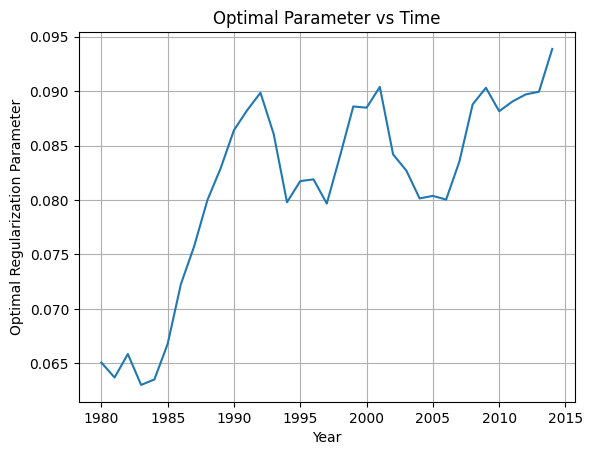

In [43]:
plt.plot(years, optimalParamaters)
plt.title('Optimal Parameter vs Time')
plt.xlabel('Year')
plt.ylabel('Optimal Regularization Parameter')
plt.grid(True)
plt.show()

### iii). Collect the predicted market values for the Elastic Net procedure, lnME_hat_EN. Then create the mispricing variable z_EN = lnME – lnME_hat_EN for each firm and year. 

In [44]:
data['lnME_hat_EN'] = np.nan

for values in lnME_hat_EN:
    data.loc[values.index, 'lnME_hat_EN'] = values
data['z_EN'] = data['lnME'] - data['lnME_hat_EN']

### iv). Create firm excess returns as ExRet = lnAnnRet – lnRf. Given how I constructed the data, this is next year’s return. Each year, run a cross-sectional regression of ExRet on an intercept and the mispricing variables z_OLS and z_EN (that is, run the FamaMacBeth regression to get the portfolio returns based on sorts on these variables). Report the slope in the Fama-MacBeth regression (the average excess portfolio return for each of z_OLS and z_EN), as well of their t-statistics ((average excess return / stdev of returns) * sqrt(T)). Are any of these signals, z_OLS or z_EN, useful for predicting returns? Which one seems best? 

In [45]:
data['ExRet'] = data['lnAnnRet'] - data['lnRf']

# regression with intercept and mispricing

### v). Choosing either z_OLS or z_EN based on which gives the highest portfolio Sharpe ratio, now run the Fama-MacBeth regressions including lnBM, lnProf, lnInv, lnMom, as well as industry dummies on the right hand side. Is the mispricing signal z that you chose marginally useful now?